#### Load packages

In [12]:
library(Biobase)
library(GEOquery)
library(limma)
library(repr)
library(edgeR)
library(preprocessCore)
library(MetaIntegrator)
library(org.Hs.eg.db)
library(Jmisc)
library(biomaRt)
library(openxlsx)

#### Paramter setting

In [13]:
#rnaseq raw data
rnaseq_data <- "../../../sra/bulk-rnaseq-datasets/"
norm_exp_data <- "../validation-dataset/"
norm_exp_data_tr <- "../working-folder/normalized-data/"
#Load the self-defined functions
sourceAll('fun/R')
#Assign Vroom connection buffer size allowing getGEO to process large data 
Sys.setenv("VROOM_CONNECTION_SIZE" = 524288 * 8)
options(width=200)

Loading...
  fun/R/aliasMapping.R 
  fun/R/array_normalize.r 
  fun/R/array_process_qc_alt.R 
  fun/R/array_process_qc.R 
  fun/R/dataset_info.R 
  fun/R/diff_exp_array_analysis.R 
  fun/R/diff_exp_seq_analysis.R 
  fun/R/draw_boxplot.R 
  fun/R/ensembl2genesymbol.R 
  fun/R/geneLength.r 
  fun/R/geo_process.R 
  fun/R/idsmap.r 
  fun/R/probe2genesymbol.R 
  fun/R/seq_process_qc.R 
  fun/R/UniqueGene_probe.r 
Done


In [14]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Amazon Linux 2

Matrix products: default
BLAS/LAPACK: /shared/software/anaconda3/envs/tb-gene-signature-update/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C               LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8     LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8    LC_PAPER=en_US.UTF-8      
 [8] LC_NAME=C                  LC_ADDRESS=C               LC_TELEPHONE=C             LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] viridis_0.6.2         viridisLite_0.4.0     openxlsx_4.2.5        biomaRt_2.46.3        Jmisc_0.3.1           org.Hs.eg.db_3.12.0   AnnotationDbi_1.52.0  IRanges_2.24.1       
 [9] S4Vectors_0.28.1      MetaIntegrator_2.1.3  preprocessCore_1.55.2 edgeR_3.32.1          repr_1.1.3   

### The studies for model validation
====TB Progression cohorts==============================================
- GSE11604: Subgroup of South African adolescents (ACS) cohort
- GSE79362: South African adolescents (ACS) cohort
- GSE94438: Grand challenges 6-74 cohort in Africa (GC6) cohort
- GSE107995: Leicester TB contact cohort
- E-MTAB-6845: London TB contacts cohort
- GSE112104: Brazilian household contact cohort
- GSE157657: Leicester (new) TB contact cohort (contacts and TB patients)

====TB treatment cohorts================================================
- GSE89403: South Africa Catalysis cohort (assess risk of treatment failure, and potential treatment shortening)
- GSE157657: Leicester (new) TB contact cohort
- GSE67589: South Africa 2015 cohort (assess risk of tuberculosis relapse following treatment)


Found 1 file(s)

GSE116014_series_matrix.txt.gz

Using locally cached version: /tmp/RtmpbMxiOI/GSE116014_series_matrix.txt.gz

Rows: 48107 Columns: 83

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): ID_REF
dbl (82): GSM3207067, GSM3207068, GSM3207069, GSM3207070, GSM3207071, GSM3207072, GSM3207073, GSM3207074, GSM3207075, GSM3207076, GSM3207077, GSM3207078, GSM3207079, GSM3207080, GSM3207081, GSM320...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Using locally cached version of GPL10558 found here:
/tmp/RtmpbMxiOI/GPL10558.soft 

Warning message:
“One or more parsing issues, see `problems()` for details”


          Length Class  Mode
GSE116014 1      -none- list
[1] "GSE116014_series_matrix.txt.gz"


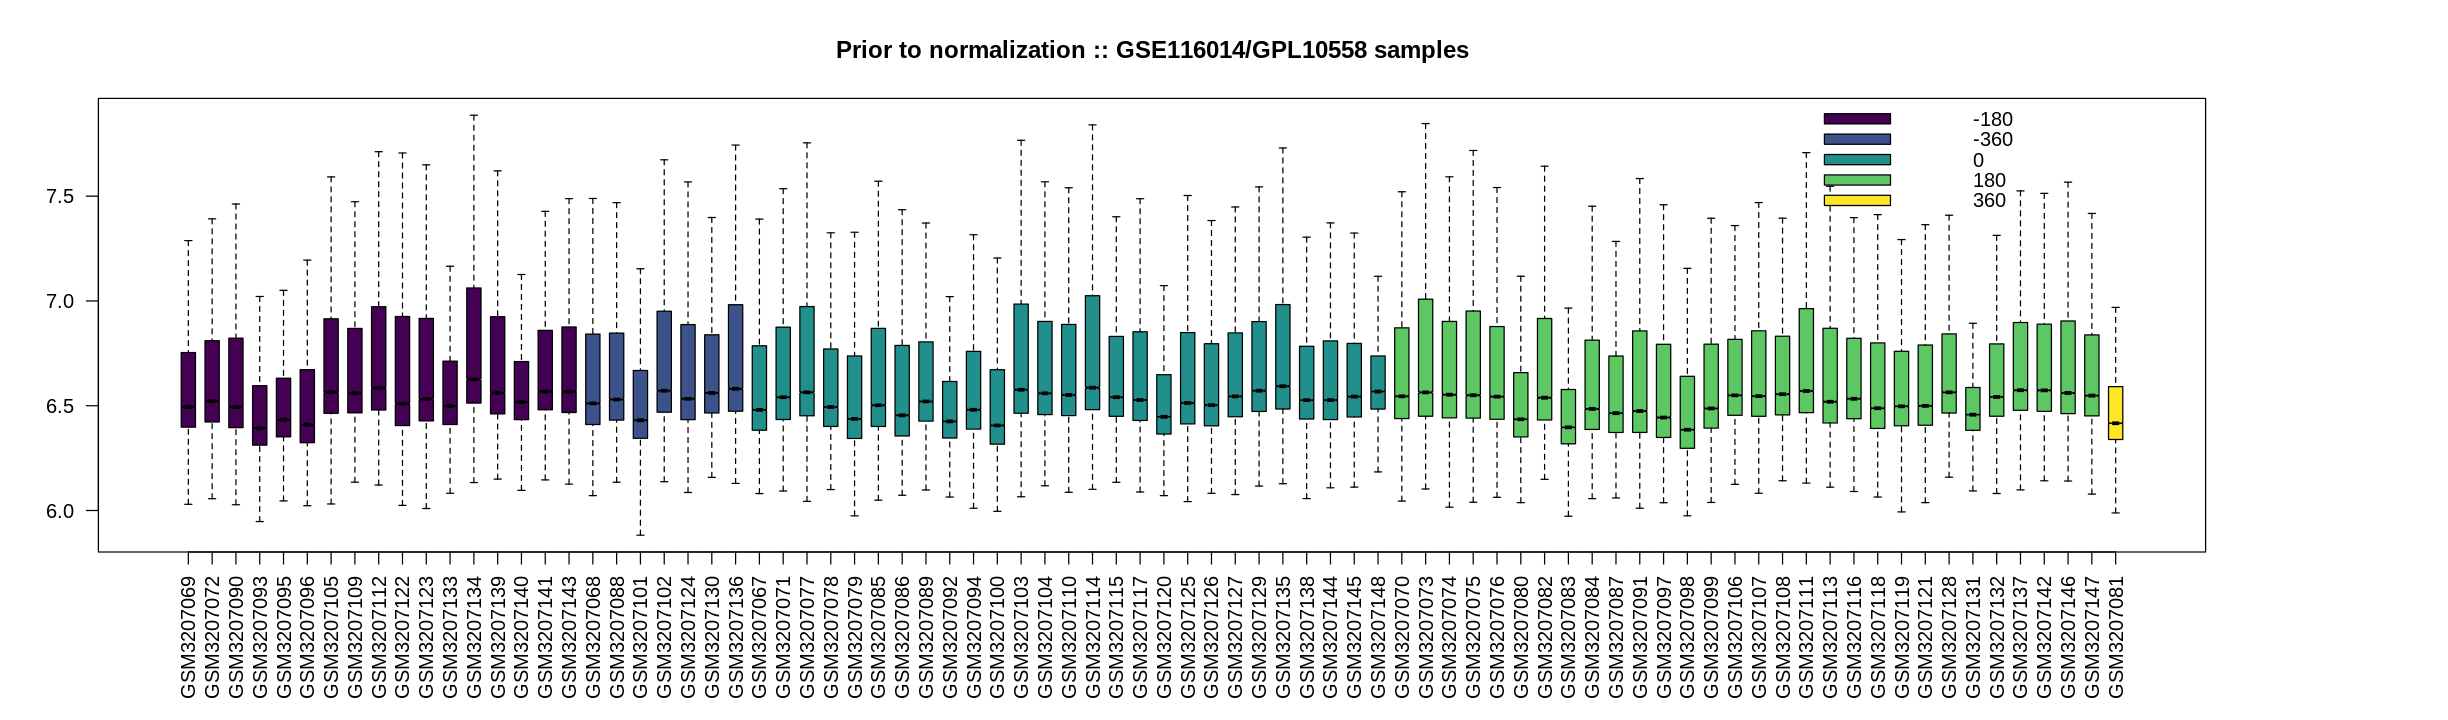

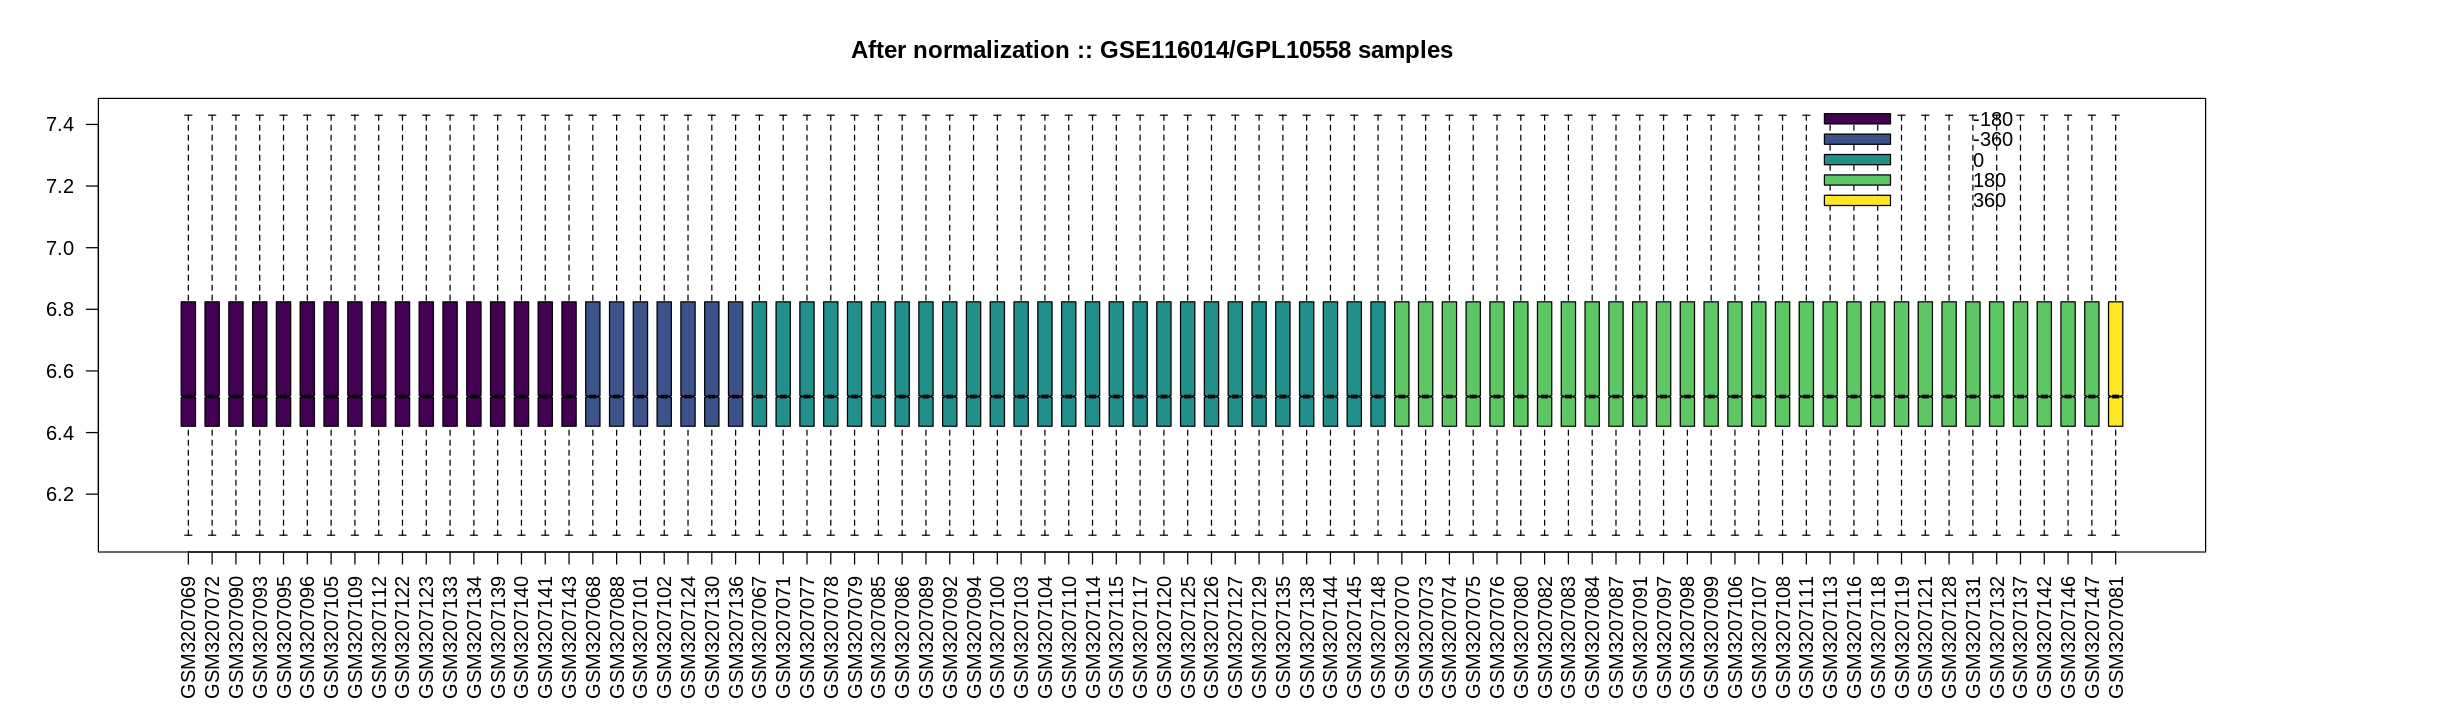

In [343]:
#Retrive GSE11604: Subgroup of South African adolescents (ACS) cohort
GSE_ID <- "GSE116014"
#Fetch and process data
data <- array_process_qc(GSE_ID, 'relative time from conversion (days):ch1', norm_exp_data, TRUE)

##################################################################
#Sort samples by time and patient
Times_HL=data$pheno[,c('patientid:ch1','relative time from conversion (days):ch1','latent tb status at blood draw:ch1')]
colnames(Times_HL)=c('patient','time','diagnosis')
Times_HL$time <- as.numeric(Times_HL$time) # it's a string originally
Times_HL$patient <- as.vector(gsub('\\/','_',gsub('ID#: ','',Times_HL$patient)))
Times_HL <- Times_HL[order(Times_HL$patient,Times_HL$time),]#Sort by patient and time

#Four groups from the cohort will be selected to construct the co-expression network 
#Group1: Day -360 and Day -180 before latent TB
#Group2: Day -180
#Group3: Day 0
#Group4: Day 180,360
Times_HL$group <- as.vector(array(0,c(dim(Times_HL)[1],1)))
Times_HL[Times_HL$time==-360,'group'] <- 1
Times_HL[Times_HL$time==-180,'group'] <- 2
Times_HL[Times_HL$time==-0,'group'] <- 3 
Times_HL[Times_HL$time==180|Times_HL$time==360,'group'] <- 4
#Finalize the sample annotations
Info <- Times_HL
Info$groupName <- as.vector(array(0,c(dim(Info)[1],1)))
Info[Info$group==1,'groupName'] <- '360d prior to infection'
Info[Info$group==2,'groupName'] <- '180d prior to infection'
Info[Info$group==3,'groupName'] <- '0d prior to infection' 
Info[Info$group==4,'groupName'] <- 'Post-infection'

#update _array_Exp_EachGene.csv _array_Exp_Info.csv
write.csv(data$gset[,rownames(Info)], paste0(norm_exp_data , GSE_ID, '_array_Exp_EachGene', '.csv'))
write.csv(Info, paste0(norm_exp_data , GSE_ID, '_array_Exp_Info', '.csv'))

[1] 354   5


Found 1 file(s)

GSE79362_series_matrix.txt.gz

Using locally cached version: /tmp/RtmpZZo0HL/GSE79362_series_matrix.txt.gz

Rows: 0 Columns: 356

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (356): ID_REF, GSM2092905, GSM2092906, GSM2092907, GSM2092908, GSM2092909, GSM2092910, GSM2092911, GSM2092912, GSM2092913, GSM2092914, GSM2092915, GSM2092916, GSM2092917, GSM2092918, GSM209291...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Using locally cached version of GPL11154 found here:
/tmp/RtmpZZo0HL/GPL11154.soft 



         Length Class  Mode
GSE79362 1      -none- list
[1] "GSE79362_series_matrix.txt.gz"



Batch submitting query [=====================>---------------------------------------------------------------------------------------------------------------------------------]  14% eta:  1m

Batch submitting query [==========================================>------------------------------------------------------------------------------------------------------------]  29% eta: 39s

Batch submitting query [================================================================>--------------------------------------------------------------------------------------]  43% eta: 25s

Batch submitting query [=====================================================================================>-----------------------------------------------------------------]  57% eta: 16s

Batch submitting query [===========================================================================================================>-------------------------------------------]  71% eta: 11s

Batch submitting query [===============

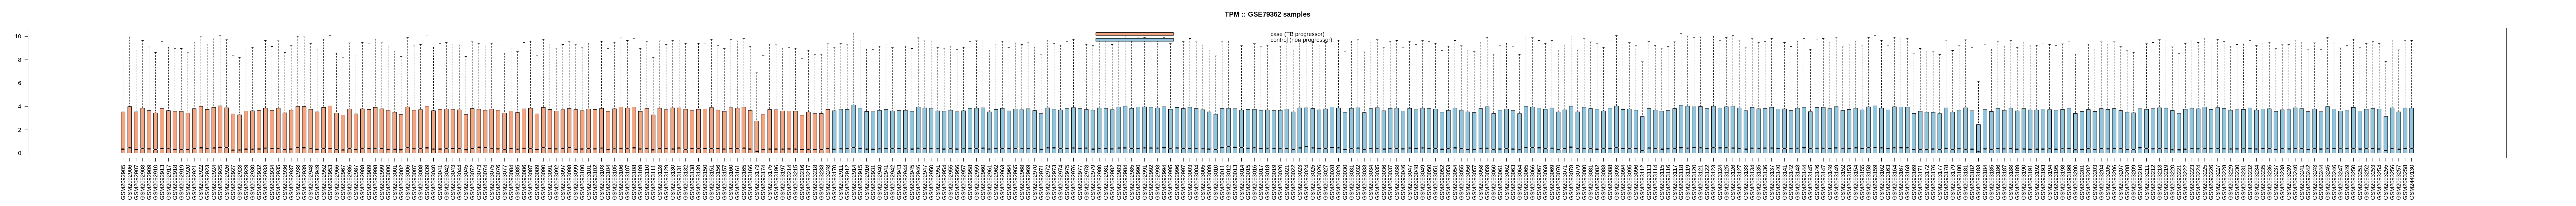

In [25]:
TBinfo <- read.xlsx(paste(rnaseq_data,'GSE79362_Phenotype_ACS.xlsx',sep=''), sheet = 'ACS_Zak1', colNames = TRUE)
rownames(TBinfo) <- paste(TBinfo[,'Subject'],gsub('D$','',TBinfo[,'Draw']),sep='_')
print(dim(TBinfo))
GSE_ID <- "GSE79362"
#Fetch and process data
data <- seq_process_qc(GSE_ID, 'group:ch1', rnaseq_data, norm_exp_data, process=2)
Pheno <- data$pheno
Name <- gsub('^.*\\(|\\).*$','',Pheno[,'title'])
ID <- Name
time <- Name
Group <- gsub('ssor.*\\(.*\\).*$','ssor',Pheno[,'title'])

Found 1 file(s)

GSE79362_series_matrix.txt.gz

Using locally cached version: /tmp/RtmpZZo0HL/GSE79362_series_matrix.txt.gz

Rows: 0 Columns: 356

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (356): ID_REF, GSM2092905, GSM2092906, GSM2092907, GSM2092908, GSM2092909, GSM2092910, GSM2092911, GSM2092912, GSM2092913, GSM2092914, GSM2092915, GSM2092916, GSM2092917, GSM2092918, GSM209291...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Using locally cached version of GPL11154 found here:
/tmp/RtmpZZo0HL/GPL11154.soft 



         Length Class  Mode
GSE79362 1      -none- list
[1] "GSE79362_series_matrix.txt.gz"



Batch submitting query [=====================>---------------------------------------------------------------------------------------------------------------------------------]  14% eta:  5s

Batch submitting query [==========================================>------------------------------------------------------------------------------------------------------------]  29% eta:  4s

Batch submitting query [================================================================>--------------------------------------------------------------------------------------]  43% eta:  3s

Batch submitting query [=====================================================================================>-----------------------------------------------------------------]  57% eta:  2s

Batch submitting query [===========================================================================================================>-------------------------------------------]  71% eta:  2s

Batch submitting query [===============

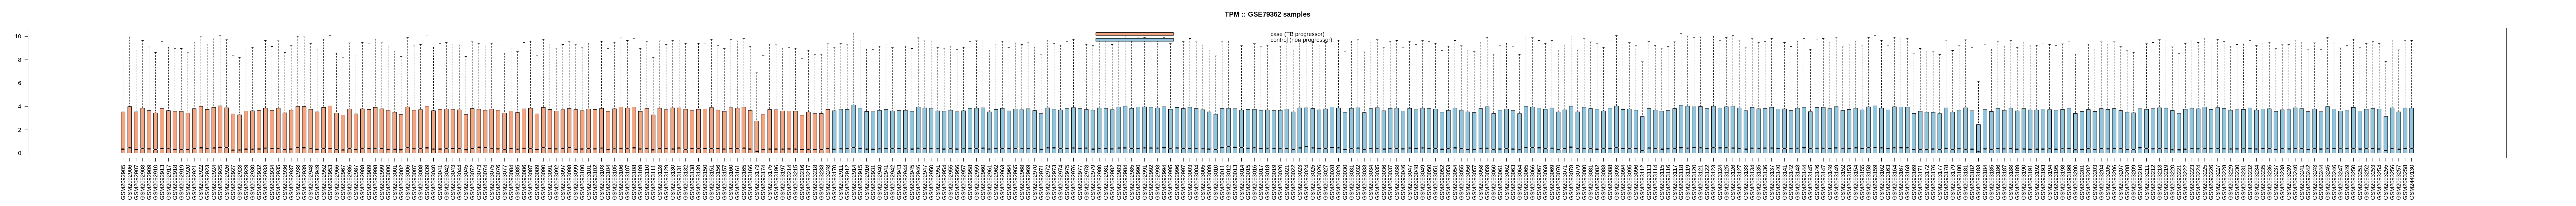

In [56]:
# GSE79362: South African adolescents (ACS) cohort
GSE_ID <- "GSE79362"
#Fetch and process data
data <- seq_process_qc(GSE_ID, 'group:ch1', rnaseq_data, norm_exp_data, process=2)

##################################################################
#time course data from Zak's supplymentary file (Zak et al paper)
TBinfo <- read.xlsx(paste(rnaseq_data,'GSE79362_Phenotype_ACS.xlsx',sep=''), sheet = 'ACS_Zak1', colNames = TRUE)
rownames(TBinfo) <- paste(TBinfo[,'Subject'],gsub('D$','',TBinfo[,'Draw']),sep='_')
Pheno <- data$pheno
Name <- gsub('^.*\\(|\\).*$','',Pheno[,'title'])
ID <- Name
time <- Name
Group <- gsub('ssor.*\\(.*\\).*$','ssor',Pheno[,'title'])
matches <- data.frame(cbind(geo_accession=Pheno[,'geo_accession'],Group),row.names=ID)
for (i in c(1:length(Name))){
    t=as.character(regmatches(ID[i],gregexpr('^\\d{2}_*\\d{4}',ID[i])))
    if (t=='character(0)'){
        t=NA;d=NA
        #t=gsub('^(\\d{1,3})_.*','\\1',ID[i]);d=NA
    }else{
        t <- gsub('^(\\d{2})_*','\\1_',t)
        d=gsub('^\\d{2}_*\\d{4}D(\\d).*$','\\1',ID[i])
        d=gsub('^\\d{2}_*\\d{4}PAXGENEDAY(\\d*)\\D*_.*$','\\1',d)
        d=gsub('^\\d{2}_*\\d{4}PAXGENE(IC)_.*$','\\1',d)
        if (d=='0'){d='000'}
    }
    ID[i]=t;time[i]=d
}
Pheno[,c('Name','ID','sampleTime','group')] <- cbind(Name,ID,time,Group)
Pheno <- cbind(Pheno,PP_time_to_diagnosis=TBinfo[paste(ID,time,sep='_'),c('PP_time_to_diagnosis')])

#Time correction
Times_ACS <- Pheno[,c('ID','sampleTime','PP_time_to_diagnosis','group','age:ch1','ethnicity:ch1','gender:ch1','bin:ch1')]
colnames(Times_ACS) <- gsub(':ch1','',colnames(Times_ACS))
Times_ACS <- Times_ACS[!is.na(Times_ACS$ID),]#Remove GC6-74 cohorts

Times_ACS$bin <- as.numeric(Times_ACS$bin);Times_ACS$age <- as.numeric(Times_ACS$age);
Times_ACS_NP <- Times_ACS[which(Times_ACS$group=='Non-progressor'),]
Times_ACS_P <- Times_ACS[which(Times_ACS$group=='TB progressor'),]
#Times_ACS_P[is.na(Times_ACS_P$sampleTime),'PP_time_to_diagnosis']=0
#Times_ACS_NP[is.na(Times_ACS_NP$sampleTime),'PP_time_to_diagnosis']='---'
#Times_ACS_NP[is.na(Times_ACS_NP$sampleTime),'sampleTime']='000'
Times_ACS_P$PP_time_to_diagnosis <- as.numeric(as.vector(Times_ACS_P$PP_time_to_diagnosis))
Times_ACS_NP <- Times_ACS_NP[order(Times_ACS_NP$ID),]#Sort by patient
Times_ACS_P <- Times_ACS_P[order(Times_ACS_P$PP_time_to_diagnosis),]#Sort by time, negative value indicates the day after active TB diagnosis  

#Five groups from the cohort will be selected to construct the co-expression network 
#Group0: No progression to active TB
#Group1: > Day -540 
#Group2: Day -540 : -360  
#Group3: Day -360 : -180 
#Group4: Day -180 : 0 
#Group5: after Day 0 
Times_ACS_P$PP_time_to_diagnosis <- -(Times_ACS_P$PP_time_to_diagnosis)#Reverse Time (negative value mean the days prior active TB) 
Times_ACS_P$group <- as.vector(array(0,c(dim(Times_ACS_P)[1],1)))
Times_ACS_P[Times_ACS_P$PP_time_to_diagnosis < -540,'group'] <- 1
Times_ACS_P[Times_ACS_P$PP_time_to_diagnosis >= -540 & Times_ACS_P$PP_time_to_diagnosis < -360,'group'] <- 2
Times_ACS_P[Times_ACS_P$PP_time_to_diagnosis >= -360 & Times_ACS_P$PP_time_to_diagnosis < -180,'group'] <- 3 
Times_ACS_P[Times_ACS_P$PP_time_to_diagnosis >= -180 & Times_ACS_P$PP_time_to_diagnosis < -0,'group'] <- 4 
Times_ACS_P[Times_ACS_P$PP_time_to_diagnosis >=0,'group'] <- 5
Times_ACS_NP$group <- as.vector(array(0,c(dim(Times_ACS_NP)[1],1)))
#Finalize the sample annotations
#Exclude samples after 90day post-active TB diagnosis 
Info <- Times_ACS_P[Times_ACS_P$PP_time_to_diagnosis <= 90,]##################Check again if necessary
Info <- rbind(Info,Times_ACS_NP[,colnames(Times_ACS_P)])
Info$groupName <- as.vector(array(0,c(dim(Info)[1],1)))
Info[Info$group==0,'groupName'] <- 'No progression'
Info[Info$group==1,'groupName'] <- '> 540d prior to ATB'
Info[Info$group==2,'groupName'] <- '540-360d prior to ATB'
Info[Info$group==3,'groupName'] <- '360-180d prior to ATB'
Info[Info$group==4,'groupName'] <- '180-0d prior to ATB' 
Info[Info$group==5,'groupName'] <- '1-90d post-ATB'

#update _array_Exp_EachGene.csv _array_Exp_Info.csv
write.csv(data$gset[,rownames(Info)], paste0(norm_exp_data , GSE_ID, '_seq_Exp_EachGene', '.csv'))
write.csv(Info, paste0(norm_exp_data , GSE_ID, '_seq_Exp_Info', '.csv'))

Found 1 file(s)

GSE94438_series_matrix.txt.gz

Using locally cached version: /tmp/RtmpbMxiOI/GSE94438_series_matrix.txt.gz

Rows: 0 Columns: 435

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (435): ID_REF, GSM2475317, GSM2475318, GSM2475319, GSM2475320, GSM2475321, GSM2475322, GSM2475323, GSM2475324, GSM2475325, GSM2475326, GSM2475327, GSM2475328, GSM2475329, GSM2475330, GSM247533...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Using locally cached version of GPL11154 found here:
/tmp/RtmpbMxiOI/GPL11154.soft 



         Length Class  Mode
GSE94438 1      -none- list
[1] "GSE94438_series_matrix.txt.gz"



Batch submitting query [=====================>---------------------------------------------------------------------------------------------------------------------------------]  14% eta: 30s

Batch submitting query [==========================================>------------------------------------------------------------------------------------------------------------]  29% eta: 25s

Batch submitting query [================================================================>--------------------------------------------------------------------------------------]  43% eta: 14s

Batch submitting query [=====================================================================================>-----------------------------------------------------------------]  57% eta:  9s

Batch submitting query [===========================================================================================================>-------------------------------------------]  71% eta:  5s

Batch submitting query [===============

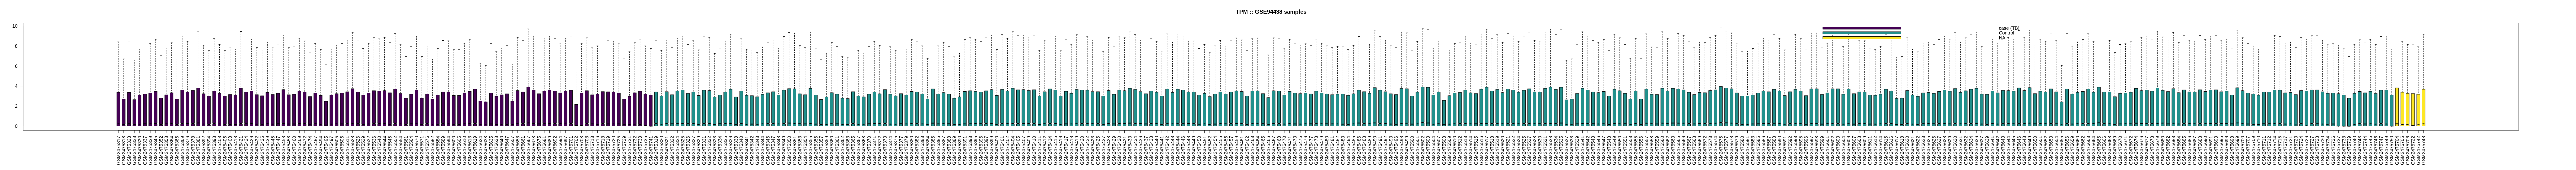

In [345]:
# GSE94438: Grand challenges 6-74 cohort in Africa (GC6) cohort
GSE_ID <- "GSE94438"
#Fetch and process data
data <- seq_process_qc(GSE_ID, 'group:ch1', rnaseq_data, norm_exp_data, process=2)

###########################################################
Pheno <- data$pheno[,c('age:ch1','code:ch1','group:ch1','site:ch1','subjectid:ch1','time.from.exposure.months:ch1','time.to.tb.months:ch1','tissue:ch1')]
colnames(Pheno)<-c('age','code','group','site','subjectid','time.from.exposure.months','time.to.tb.months','tissue')
Pheno <-cbind(GSM=rownames(Pheno),Pheno)
Pheno$group <- gsub('^case \\(TB\\)$','Case',Pheno$group)
#Add back the missing values in GEO dataset based on the table (GSE94438.200527_GC6.transcriptomics.metadata.xlsx)
Pheno[Pheno$code=='672',c('age','group','site','subjectid','time.from.exposure.months','time.to.tb.months')] <- c('32','Case','UAD','92245','0','6')
Pheno[Pheno$code=='694',c('age','group','site','subjectid','time.from.exposure.months','time.to.tb.months')] <- c('34','Control','UAD','91420103','0','NA')
Pheno[Pheno$code=='695',c('age','group','site','subjectid','time.from.exposure.months','time.to.tb.months')] <- c('28','Control','UAD','91451104','0','NA')
Pheno[Pheno$code=='994',c('age','group','site','subjectid','time.from.exposure.months','time.to.tb.months')] <- c('40','Control','AHRI','KHHC87','18','NA')
Pheno[Pheno$code=='1061',c('age','group','site','subjectid','time.from.exposure.months','time.to.tb.months')] <- c('24','Control','AHRI','DZHHC06','6','NA')
Pheno[Pheno$code=='1194',c('age','group','site','subjectid','time.from.exposure.months','time.to.tb.months')] <- c('18','Control','AHRI','KAZHHC23','18','NA')
#Calculate sampling time to TB incidence and convert to day unit 
Pheno[Pheno$group=='Case','Sampletime_to_TB'] <- (as.numeric(Pheno[Pheno$group=='Case','time.from.exposure.months'])-as.numeric(Pheno[Pheno$group=='Case','time.to.tb.months']))*30
Pheno[Pheno$site=='MRC','subjectid']=paste('20',Pheno[Pheno$site=='MRC','subjectid'],sep='')
#Remove duplicated RNAseq run
Pheno <- Pheno[!duplicated(Pheno$code),]

TBinfo.p <- read.xlsx(paste(rnaseq_data,'GSE94438.200527_GC6.transcriptomics.metadata.xlsx',sep=''), sheet = 'Progressors_clean', colNames = TRUE)
TBinfo.np <- read.xlsx(paste(rnaseq_data,'GSE94438.200527_GC6.transcriptomics.metadata.xlsx',sep=''), sheet = 'Nonprogressors_clean', colNames = TRUE)
colnames(TBinfo.p)[2]='subjectid'
colnames(TBinfo.np)[2]='subjectid'
TBinfo.np[TBinfo.np$X1=='The Gambia','subjectid'] <- paste('20',TBinfo.np[TBinfo.np$X1=='The Gambia','subjectid'],sep='')
TBinfo.np[TBinfo.np$X1=='The Gambia','Matched.Progressor.ID'] <- paste('20',TBinfo.np[TBinfo.np$X1=='The Gambia','Matched.Progressor.ID'],sep='')
TBinfo.p[,c('subjectid','Gender')] <- apply(TBinfo.p[,c('subjectid','Gender')],2,function(x)gsub('\\s+','',x))
TBinfo.np[,c('subjectid','Gender','Matched.Progressor.ID')] <- apply(TBinfo.np[,c('subjectid','Gender','Matched.Progressor.ID')],2,function(x)gsub('\\s+','',x))
Pheno <- merge(Pheno,TBinfo.p[,c('X1','subjectid','Gender','Culture+.(n)','Smear+.(n)','Chest.X-Ray','Symptoms.(n)','Other','Classification','Category')],by="subjectid",all.x=TRUE)
Pheno <- merge(Pheno,TBinfo.np[,c('subjectid','Matched.Progressor.ID')],by="subjectid",all.x=TRUE)
for (id in Pheno[Pheno$group=='Control','subjectid']){
    Pheno[Pheno$subjectid==id,c('X1','Gender','Category')]<-TBinfo.np[TBinfo.np$subjectid==id,c('X1','Gender','Category')]
}
#Put sequence sample ID as rownames
rownames(Pheno)<-Pheno$code
#Change X1 to siteName
colnames(Pheno)[colnames(Pheno)=='X1'] <- 'siteName'
                                                                                                                                 
#Time correction
Times_GC6_74 <- Pheno
Times_GC6_74_NP <- Times_GC6_74[which(Times_GC6_74$group=='Control'),]
Times_GC6_74_P <- Times_GC6_74[which(Times_GC6_74$group=='Case'),]
Times_GC6_74_NP <- Times_GC6_74_NP[order(Times_GC6_74_NP$subjectid),]#Sort by patient
Times_GC6_74_P <- Times_GC6_74_P[order(Times_GC6_74_P$Sampletime_to_TB),]#Sort by time, negative value indicates the day after active TB diagnosis  

#For the non-progressors, every subject was monitored 18 months. No need to further down-selection

#Five groups from the cohort will be selected to construct the co-expression network 
#Group0: No progression to active TB
#Group1: > Day -540 
#Group2: Day -540 : -360  
#Group3: Day -360 : -180 
#Group4: Day -180 : 0 
#Group5: after Day 0 
Times_GC6_74_P$group <- as.vector(array(0,c(dim(Times_GC6_74_P)[1],1)))
Times_GC6_74_P[Times_GC6_74_P$Sampletime_to_TB < -540,'group'] <- 1
Times_GC6_74_P[Times_GC6_74_P$Sampletime_to_TB >= -540 & Times_GC6_74_P$Sampletime_to_TB < -360,'group'] <- 2
Times_GC6_74_P[Times_GC6_74_P$Sampletime_to_TB >= -360 & Times_GC6_74_P$Sampletime_to_TB < -180,'group'] <- 3 
Times_GC6_74_P[Times_GC6_74_P$Sampletime_to_TB >= -180 & Times_GC6_74_P$Sampletime_to_TB < -0,'group'] <- 4 
Times_GC6_74_P[Times_GC6_74_P$Sampletime_to_TB >=0,'group'] <- 5
Times_GC6_74_NP$group <- as.vector(array(0,c(dim(Times_GC6_74_NP)[1],1)))
#Finalize the sample annotations
Info <- rbind(Times_GC6_74_P,Times_GC6_74_NP[,colnames(Times_GC6_74_P)])
Info$groupName <- as.vector(array(0,c(dim(Info)[1],1)))
Info[Info$group==0,'groupName'] <- 'No progression'
Info[Info$group==1,'groupName'] <- '> 540d prior to ATB'
Info[Info$group==2,'groupName'] <- '540-360d prior to ATB'
Info[Info$group==3,'groupName'] <- '360-180d prior to ATB'
Info[Info$group==4,'groupName'] <- '180-0d prior to ATB' 
Info[Info$group==5,'groupName'] <- 'Post-ATB'
rownames(Info) <- Info$GSM

#update _array_Exp_EachGene.csv _array_Exp_Info.csv
write.csv(data$gset[,rownames(Info)], paste0(norm_exp_data , GSE_ID, '_seq_Exp_EachGene', '.csv'))
write.csv(Info, paste0(norm_exp_data , GSE_ID, '_seq_Exp_Info', '.csv'))


Batch submitting query [=====================>---------------------------------------------------------------------------------------------------------------------------------]  14% eta: 18s

Batch submitting query [==========================================>------------------------------------------------------------------------------------------------------------]  29% eta: 13s

Batch submitting query [================================================================>--------------------------------------------------------------------------------------]  43% eta: 13s

Batch submitting query [=====================================================================================>-----------------------------------------------------------------]  57% eta: 10s

Batch submitting query [===========================================================================================================>-------------------------------------------]  71% eta:  6s

Batch submitting query [===============

          Length Class  Mode
GSE107993 1      -none- list
[1] "GSE107993_series_matrix.txt.gz"


Found 1 file(s)

GSE107994_series_matrix.txt.gz

Using locally cached version: /tmp/RtmpwGtHTI/GSE107994_series_matrix.txt.gz

Rows: 0 Columns: 176

── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (176): ID_REF, GSM2886274, GSM2886275, GSM2886276, GSM2886277, GSM2886278, GSM2886279, GSM2886280, GSM2886281, GSM2886282, GSM2886283, GSM2886284, GSM2886285, GSM2886286, GSM2886287, GSM288628...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Using locally cached version of GPL20301 found here:
/tmp/RtmpwGtHTI/GPL20301.soft 



          Length Class  Mode
GSE107994 1      -none- list
[1] "GSE107994_series_matrix.txt.gz"


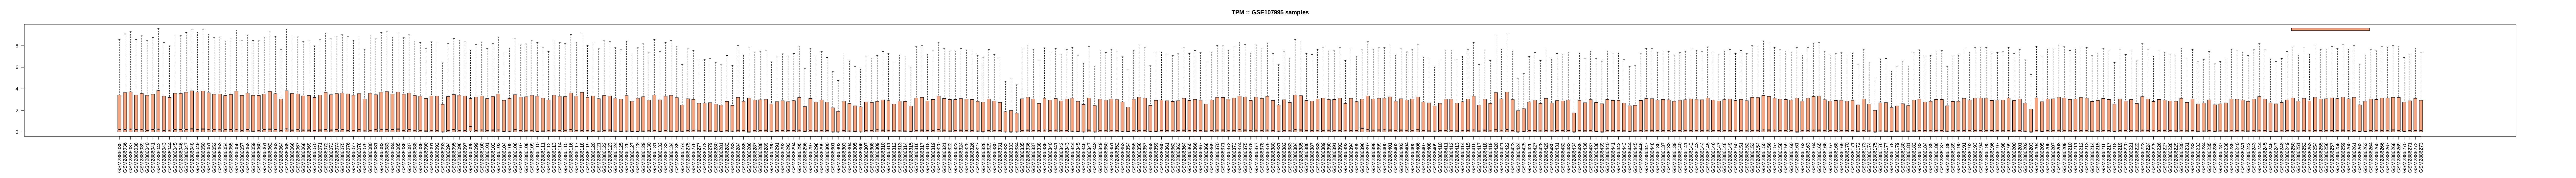

In [33]:
# GSE107995: Leicester TB contact cohort
GSE_ID <- "GSE107995"
#Fetch and process data
data <- seq_process_qc(GSE_ID, '', rnaseq_data, norm_exp_data, process=2, pheno_fetch=0)

###########################################################
# GSE107995 is collection of GSE107994 and GSE107993
gse <- getGEOData('GSE107993')
Pheno1 <- gse$originalData$GSE107993$pheno
#GSE107994 :Leicester progressor
gse <- getGEOData('GSE107994')
Pheno2 <- gse$originalData$GSE107994$pheno
Pheno1 <- Pheno1[,c('title','geo_accession','patient_id:ch1','age_at_baseline_visit:ch1','ethnicity:ch1','gender:ch1','group:ch1','timepoint_months:ch1','uk_arrival_year:ch1','visit_date:ch1')]
colnames(Pheno1) <- gsub(':ch1$','',colnames(Pheno1))
Pheno1 <- cbind(cbind(Pheno1,time_to_TB_diagnosed=NA),sampleTime=0)
Pheno2 <- Pheno2[,c('title','geo_accession','patient_id:ch1','age_at_baseline_visit:ch1','ethnicity:ch1','gender:ch1','group:ch1','timepoint_months:ch1','uk_arrival_year:ch1','visit_date:ch1')]
colnames(Pheno2) <- gsub(':ch1$','',colnames(Pheno2))
Pheno2 <- cbind(cbind(Pheno2,time_to_TB_diagnosed=NA),sampleTime=0)
Pheno2[Pheno2$group=='Active_TB','time_to_TB_diagnosed']=0

#Calculate time to TB diagnosed
for (id in unique(Pheno2$patient_id)){
    t <- Pheno2[Pheno2$patient_id==id,]
    if (dim(t)[1]>1){
        #Find the sample ID which is in the disgnosed stage
        diagnose.s <- rownames(t)[which(grepl('Active_TB_diagnosed', t$timepoint_months))]
        for (id in rownames(t)){
            Pheno2[id,'time_to_TB_diagnosed'] <- as.numeric(as.Date(as.character(Pheno2[id,'visit_date']), format="%Y-%m-%d")-as.Date(as.character(Pheno2[diagnose.s,'visit_date']), format="%Y-%m-%d"))
        }
    }
}
Pheno <- rbind(Pheno1,Pheno2)
#Calculate time to sampling time
for (id in unique(Pheno$patient_id)){
    t <- Pheno[Pheno$patient_id==id,]
    if (dim(t)[1]>1){
        #Find the sample ID which is in the disgnosed stage
        baseline.s <- rownames(t)[which(grepl('Baseline', t$timepoint_months))][1]
        for (id in rownames(t)){
            Pheno[id,'sampleTime'] <- as.numeric(as.Date(as.character(Pheno[id,'visit_date']), format="%Y-%m-%d")-as.Date(as.character(Pheno[baseline.s,'visit_date']), format="%Y-%m-%d"))
        }
    }
}
rownames(Pheno) <- Pheno$title

#Time correction
Times_Leicester <- Pheno
colnames(Times_Leicester)[which(colnames(Times_Leicester)=='group')] <- 'class'
Times_Leicester_NP <- Times_Leicester[which(Times_Leicester$class=='Control'|Times_Leicester$class=='LTBI'),]
Times_Leicester_P <- Times_Leicester[which(Times_Leicester$class=='LTBI_Progressor'|Times_Leicester$class=='Active_TB'),]
Times_Leicester_NP <- Times_Leicester_NP[order(Times_Leicester_NP$patient_id,Times_Leicester_NP$visit_date),]#Sort by patient
Times_Leicester_P <- Times_Leicester_P[order(Times_Leicester_P$time_to_TB_diagnosed),]#Sort by time, negative value indicates the day after active TB diagnosis  

#For the non-progressors, we down-selected the participants who were followed up at least 5 months (only a few subjects have more than 12 months follow up)
inc <-c()
for (pid in unique(Times_Leicester_NP$patient_id)){
    t <- Times_Leicester_NP[Times_Leicester_NP$patient_id==pid,]
    times <-t[order(t$visit_date),'visit_date']
    if (as.numeric(as.Date(as.character(times[length(times)]), format="%Y-%m-%d")-as.Date(as.character(times[1]), format="%Y-%m-%d"))>=150){inc<-c(inc,which(Times_Leicester_NP$patient_id==pid))}
}
Times_Leicester_NP <- Times_Leicester_NP[inc,]

#Five groups from the cohort will be selected to construct the co-expression network 
#Group0: No progression to active TB
#Group4: Day -180 : 0 
#Group5: after Day 0 
Times_Leicester_P$group <- as.vector(array(0,c(dim(Times_Leicester_P)[1],1)))
Times_Leicester_P[Times_Leicester_P$time_to_TB_diagnosed >= -180 & Times_Leicester_P$time_to_TB_diagnosed < 0,'group'] <- 4 
Times_Leicester_P[Times_Leicester_P$time_to_TB_diagnosed >=0,'group'] <- 5
Times_Leicester_NP$group <- as.vector(array(0,c(dim(Times_Leicester_NP)[1],1)))
#Finalize the sample annotations
Info <- rbind(Times_Leicester_P,Times_Leicester_NP[,colnames(Times_Leicester_P)])
Info$groupName <- as.vector(array(0,c(dim(Info)[1],1)))
Info[Info$group==0,'groupName'] <- 'No progression'
Info[Info$group==4,'groupName'] <- '180-0d prior to ATB' 
Info[Info$group==5,'groupName'] <- 'Post-ATB'
rownames(Info)=Info$geo_accession

#update _array_Exp_EachGene.csv _array_Exp_Info.csv
write.csv(data$gset[,rownames(Info)], paste0(norm_exp_data , GSE_ID, '_seq_Exp_EachGene', '.csv'))
write.csv(Info, paste0(norm_exp_data , GSE_ID, '_seq_Exp_Info', '.csv'))


Batch submitting query [=============================>-------------------------------------------------------------------------------------------------------------------------]  20% eta: 14s

Batch submitting query [===========================================================>-------------------------------------------------------------------------------------------]  40% eta:  9s

Batch submitting query [==========================================================================================>------------------------------------------------------------]  60% eta:  6s

Batch submitting query [========================================================================================================================>------------------------------]  80% eta:  4s
                                                                                                                                                                                              



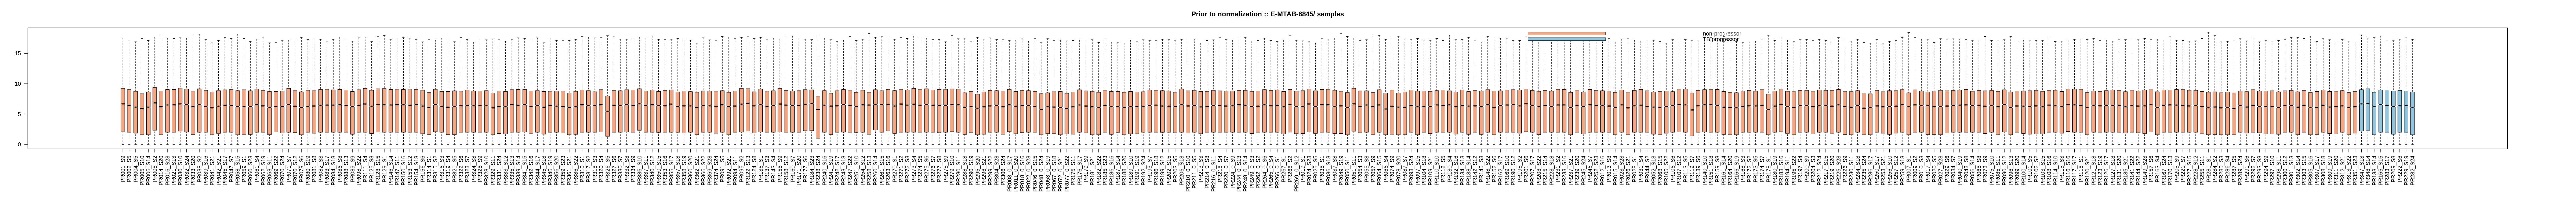

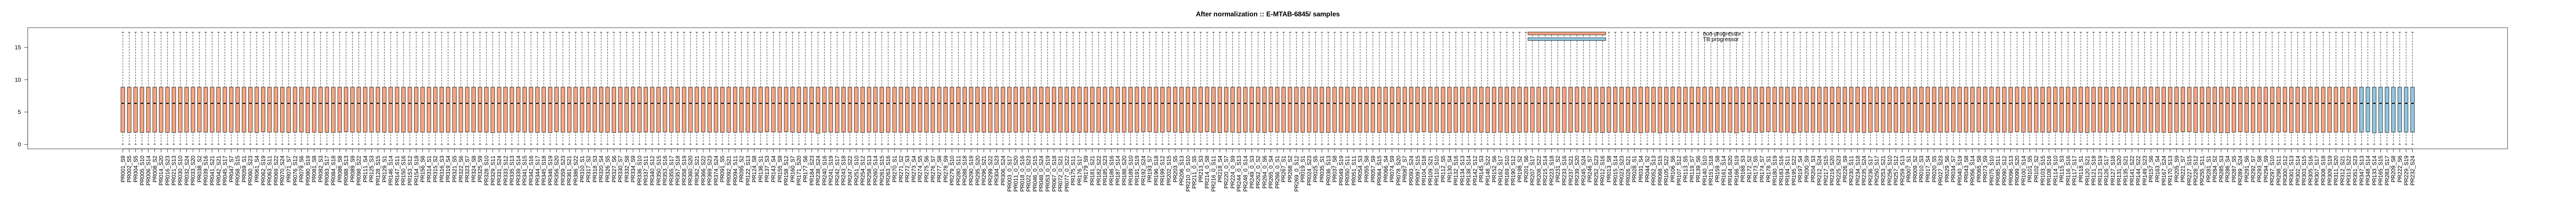

In [31]:
# E-MTAB-6845: London TB contacts cohort
GSE_ID <- "E-MTAB-6845"
#Fetch and process data
data <- array_process_qc(GSE_ID, 'status', norm_exp_data, TRUE)

###########################################################
#Time correction
Times_London <- data$pheno[,-1]
Times_London_NP <- Times_London[which(Times_London$status=='non-progressor'),]
Times_London_P <- Times_London[which(Times_London$status=='TB progressor'),]
Times_London_NP <- Times_London_NP[order(rownames(Times_London_NP)),]#Sort by patient
Times_London_P <- Times_London_P[order(Times_London_P$days_to_tb_diagnosis),]#Sort by time, negative value indicates the day after active TB diagnosis  

#For the non-progressors, filter out subjects who has preventative tuberculosis treatment
Times_London_NP <- Times_London_NP[Times_London_NP[,'preventative tuberculosis treatment']=='no',]

#Five groups from the cohort will be selected to construct the co-expression network 
#Group0: No progression to active TB
#Group1: > Day -540 
#Group3: Day -360 : -180 
#Group4: Day -180 : 0 
Times_London_P$group <- as.vector(array(0,c(dim(Times_London_P)[1],1)))
Times_London_P[Times_London_P$days_to_tb_diagnosis < -540,'group'] <- 1
Times_London_P[Times_London_P$days_to_tb_diagnosis >= -360 & Times_London_P$days_to_tb_diagnosis < -180,'group'] <- 3 
Times_London_P[Times_London_P$days_to_tb_diagnosis >= -180 & Times_London_P$days_to_tb_diagnosis < -0,'group'] <- 4 
Times_London_NP$group <- as.vector(array(0,c(dim(Times_London_NP)[1],1)))
#Finalize the sample annotations
Info <- rbind(Times_London_P,Times_London_NP[,colnames(Times_London_P)])
Info$groupName <- as.vector(array(0,c(dim(Info)[1],1)))
Info[Info$group==0,'groupName'] <- 'No progression'
Info[Info$group==1,'groupName'] <- '> 540d prior to ATB'
Info[Info$group==3,'groupName'] <- '360-180d prior to ATB' 
Info[Info$group==4,'groupName'] <- '180-0d prior to ATB'
#Remove IGRA negative samples
#Info <- Info[Info[,'interferon gamma release assa']=='positive'|Info$status=='TB progressor',]

#update _array_Exp_EachGene.csv _array_Exp_Info.csv
write.csv(data$gset[,rownames(Info)], paste0(norm_exp_data , GSE_ID, '_array_Exp_EachGene', '.csv'))
write.csv(Info, paste0(norm_exp_data , GSE_ID, '_array_Exp_Info', '.csv'))

Found 1 file(s)

GSE112104_series_matrix.txt.gz

Using locally cached version: /tmp/RtmpbMxiOI/GSE112104_series_matrix.txt.gz

Rows: 0 Columns: 52

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (52): ID_REF, GSM3057807, GSM3057808, GSM3057809, GSM3057810, GSM3057811, GSM3057812, GSM3057813, GSM3057814, GSM3057815, GSM3057816, GSM3057817, GSM3057818, GSM3057819, GSM3057820, GSM3057821...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Using locally cached version of GPL16791 found here:
/tmp/RtmpbMxiOI/GPL16791.soft 



          Length Class  Mode
GSE112104 1      -none- list
[1] "GSE112104_series_matrix.txt.gz"



Batch submitting query [=====================>---------------------------------------------------------------------------------------------------------------------------------]  14% eta: 32s

Batch submitting query [==========================================>------------------------------------------------------------------------------------------------------------]  29% eta: 20s

Batch submitting query [================================================================>--------------------------------------------------------------------------------------]  43% eta: 16s

Batch submitting query [=====================================================================================>-----------------------------------------------------------------]  57% eta: 12s

Batch submitting query [===========================================================================================================>-------------------------------------------]  71% eta:  8s

Batch submitting query [===============

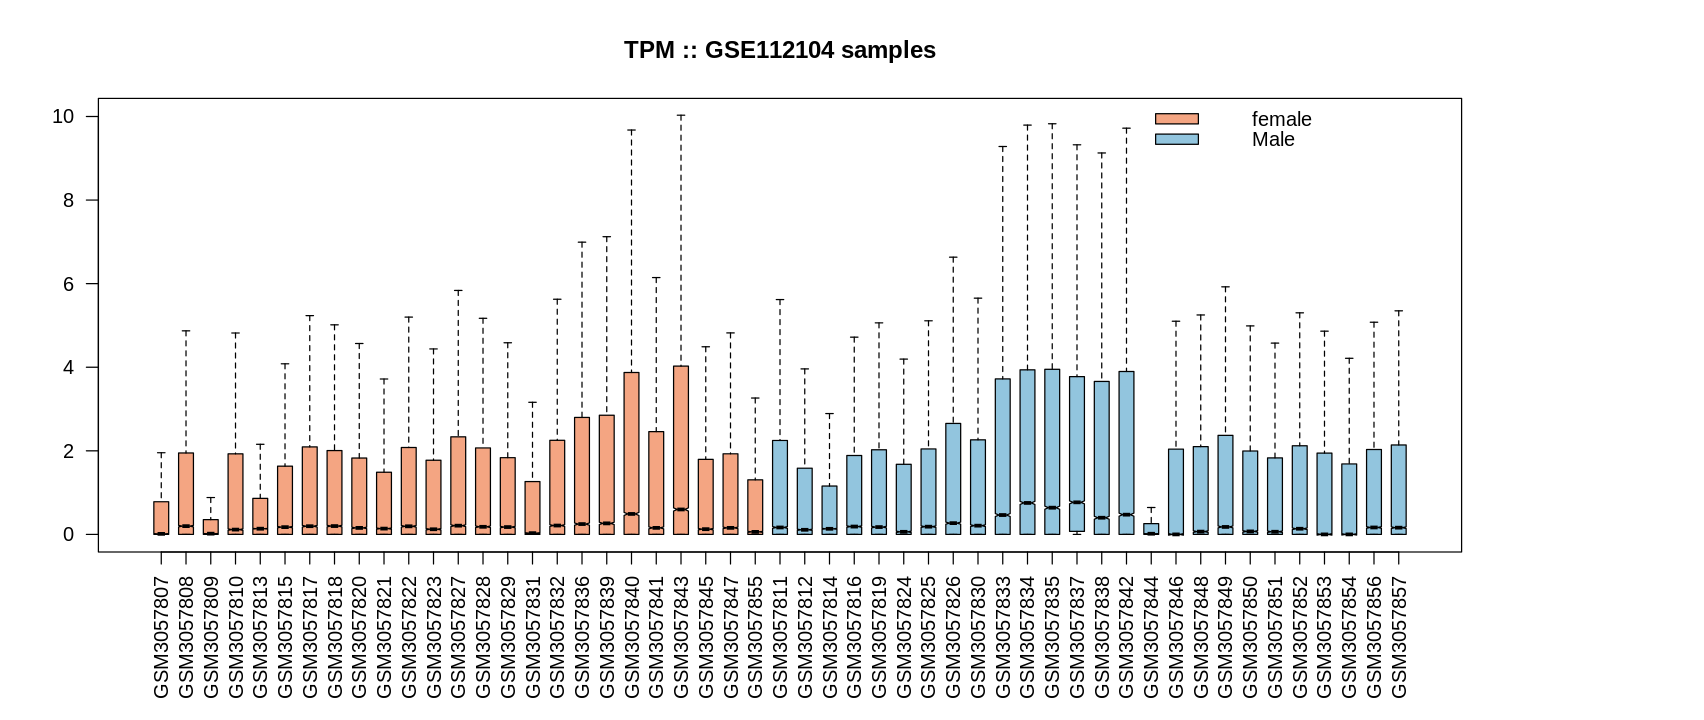

In [348]:
# GSE112104: Brazilian household contact cohort
GSE_ID <- "GSE112104"
#Fetch and process data
data <- seq_process_qc(GSE_ID, 'gender:ch1', rnaseq_data, norm_exp_data, process=2)

###########################################################
#Time correction
Times_ACS <- data$pheno[,c('source_name_ch1','age:ch1','days_to_tb:ch1','gender:ch1')]
colnames(Times_ACS) <- c('type','age','days_to_tb','gender')
Times_ACS$type<-gsub('\\s\\d+','',Times_ACS$type)
Times_ACS_NP <- Times_ACS[which(Times_ACS$type=='Non-progressor'),]
Times_ACS_P <- Times_ACS[which(Times_ACS$type=='Progressor'| Times_ACS$type=='Tuberculosis patient'),]
Times_ACS_P$days_to_tb  <- as.numeric(as.vector(Times_ACS_P$days_to_tb ))

#Five groups from the cohort will be selected to construct the co-expression network 
#Group0: No progression to active TB
#Group1: < Day -720
#Group2: Day -720: -540 
#Group3: Day -540 : -360  
#Group4: Day -360 : -180 
#Group5: Day -180 : 0 
#Group6: after Day 0 
Times_ACS_P$days_to_tb <- -(Times_ACS_P$days_to_tb)#Reverse Time (negative value mean the days prior active TB) 
Times_ACS_P$group <- as.vector(array(0,c(dim(Times_ACS_P)[1],1)))
Times_ACS_P[Times_ACS_P$days_to_tb < -720,'group'] <- 1
Times_ACS_P[Times_ACS_P$days_to_tb >= -720 & Times_ACS_P$days_to_tb < -540,'group'] <- 2
Times_ACS_P[Times_ACS_P$days_to_tb >= -540 & Times_ACS_P$days_to_tb < -360,'group'] <- 3
Times_ACS_P[Times_ACS_P$days_to_tb >= -360 & Times_ACS_P$days_to_tb < -180,'group'] <- 4 
Times_ACS_P[Times_ACS_P$days_to_tb >= -180 & Times_ACS_P$days_to_tb < -0,'group'] <- 5 
Times_ACS_P[Times_ACS_P$days_to_tb >=0,'group'] <- 6
Times_ACS_NP$group <- as.vector(array(0,c(dim(Times_ACS_NP)[1],1)))
#Finalize the sample annotations
Info <- rbind(Times_ACS_P,Times_ACS_NP)
Info$groupName <- as.vector(array(0,c(dim(Info)[1],1)))
Info[Info$group==0,'groupName'] <- 'No progression'
Info[Info$group==1,'groupName'] <- '> 720d prior to ATB'
Info[Info$group==2,'groupName'] <- '720-540d prior to ATB'
Info[Info$group==3,'groupName'] <- '540-360d prior to ATB'
Info[Info$group==4,'groupName'] <- '360-180d prior to ATB'
Info[Info$group==5,'groupName'] <- '180-0d prior to ATB' 
Info[Info$group==6,'groupName'] <- '1-90d post-ATB'

#update _array_Exp_EachGene.csv _array_Exp_Info.csv
write.csv(data$gset[,rownames(Info)], paste0(norm_exp_data , GSE_ID, '_seq_Exp_EachGene', '.csv'))
write.csv(Info, paste0(norm_exp_data , GSE_ID, '_seq_Exp_Info', '.csv'))

Found 1 file(s)

GSE157657_series_matrix.txt.gz

Using locally cached version: /tmp/Rtmpo59dRt/GSE157657_series_matrix.txt.gz

Rows: 0 Columns: 761

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (761): ID_REF, GSM4772183, GSM4772184, GSM4772185, GSM4772186, GSM4772187, GSM4772188, GSM4772189, GSM4772190, GSM4772191, GSM4772192, GSM4772193, GSM4772194, GSM4772195, GSM4772196, GSM477219...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Using locally cached version of GPL20301 found here:
/tmp/Rtmpo59dRt/GPL20301.soft 



          Length Class  Mode
GSE157657 1      -none- list
[1] "GSE157657_series_matrix.txt.gz"


Ensembl site unresponsive, trying uswest mirror


Batch submitting query [=====================>---------------------------------------------------------------------------------------------------------------------------------]  14% eta:  3m

Batch submitting query [==========================================>------------------------------------------------------------------------------------------------------------]  29% eta:  1m

Batch submitting query [================================================================>--------------------------------------------------------------------------------------]  43% eta:  1m

Batch submitting query [=====================================================================================>-----------------------------------------------------------------]  57% eta: 41s

Batch submitting query [===========================================================================================================>-------------------------------------------]  71% 

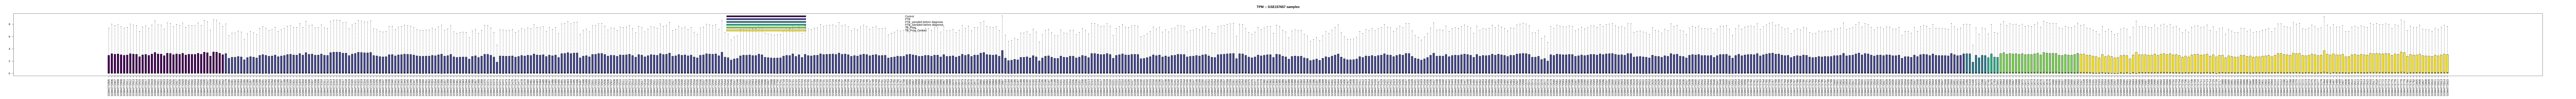

In [21]:
#Retrive GSE157657: Leicester (new) TB contact cohort
GSE_ID <- "GSE157657"
#Fetch and process data
data <- seq_process_qc(GSE_ID, 'group:ch1', rnaseq_data, norm_exp_data, process=2)

##################################################################
Info=data$pheno[,c('patient id:ch1','age:ch1','categories_progressors:ch1','days_from_att:ch1','ethnicity:ch1', 'gender:ch1','group:ch1','culture_result:ch1','igra:ch1','smear_results:ch1','subgroup_att:ch1','subgroup:ch1','resistance:ch1','response_group:ch1','timepoint_progressors:ch1')]
colnames(Info)=gsub(':ch1','',colnames(Info))
Info$days_from_att <- as.numeric(as.vector(Info$days_from_att))

#update _array_Exp_EachGene.csv _array_Exp_Info.csv
write.csv(data$gset[,rownames(Info)], paste0(norm_exp_data , GSE_ID, '_seq_Exp_EachGene', '.csv'))
write.csv(Info, paste0(norm_exp_data , GSE_ID, '_seq_Exp_Info', '.csv'))

Found 1 file(s)

GSE89403_series_matrix.txt.gz

Using locally cached version: /tmp/RtmpXZQ0us/GSE89403_series_matrix.txt.gz

Rows: 0 Columns: 915

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (915): ID_REF, GSM2369703, GSM2369704, GSM2369705, GSM2369706, GSM2369707, GSM2369708, GSM2369709, GSM2369710, GSM2369711, GSM2369712, GSM2369713, GSM2369714, GSM2369715, GSM2369716, GSM236971...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Using locally cached version of GPL11154 found here:
/tmp/RtmpXZQ0us/GPL11154.soft 



         Length Class  Mode
GSE89403 1      -none- list
[1] "GSE89403_series_matrix.txt.gz"



Batch submitting query [=====================>---------------------------------------------------------------------------------------------------------------------------------]  14% eta:  2m

Batch submitting query [==========================================>------------------------------------------------------------------------------------------------------------]  29% eta:  1m

Batch submitting query [================================================================>--------------------------------------------------------------------------------------]  43% eta: 40s

Batch submitting query [=====================================================================================>-----------------------------------------------------------------]  57% eta: 26s

Batch submitting query [===========================================================================================================>-------------------------------------------]  71% eta: 16s

Batch submitting query [===============

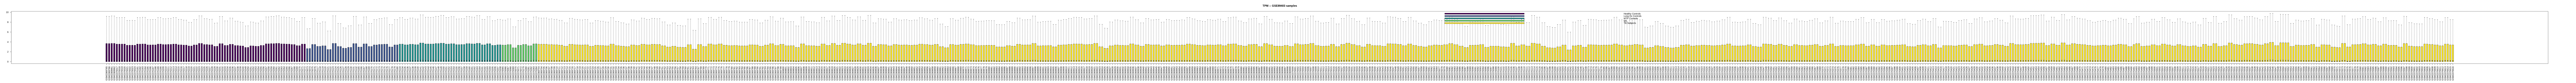

In [6]:
# GSE89403: South Africa Catalysis cohort
GSE_ID <- "GSE89403"
#Fetch and process data
data <- seq_process_qc(GSE_ID, 'disease state:ch1', rnaseq_data, norm_exp_data, process=2)

###########################################################

#Remove the duplicated data from the same samples.
uni <- which(duplicated(data$pheno[,'sample_code:ch1'])==FALSE)
data$pheno <- data$pheno[uni,]
data$pheno <- data$pheno[data$pheno[,'subject:ch1']!='NA',]
data$gset <- data$gset[,rownames(data$pheno)]

Info_AH1 <- data$pheno[,c('disease state:ch1','subject:ch1','time:ch1','timetonegativity:ch1','treatmentresult:ch1','mgit:ch1','tgrv:ch1','xpert:ch1')]
colnames(Info_AH1) <- gsub(':ch1','',colnames(Info_AH1))
#Divide the cohort into 3 parts : Health control, Cure after Treatment, Not cured after treatment
Info_AH1_Healthy <- Info_AH1[which(Info_AH1[,'disease state']=='Healthy Controls'),]
Info_AH1_Healthy$time <- gsub('week_24','168',gsub('week_8','56',gsub('week_4','28',gsub('day_','',gsub('DX','0',Info_AH1_Healthy$time)))))#Convert weeks to days
Info_AH1_Healthy$time <- as.numeric(Info_AH1_Healthy$time)
Info_AH1_TB_noCure <- Info_AH1[which(Info_AH1[,'disease state']=='TB Subjects' & Info_AH1[,'treatmentresult']=='Not Cured'),]
Info_AH1_TB_noCure <- Info_AH1_TB_noCure[order(Info_AH1_TB_noCure[,'subject'],Info_AH1_TB_noCure[,'time']),]
Info_AH1_TB_noCure$time <- gsub('week_24','168',gsub('week_8','56',gsub('week_4','28',gsub('day_','',gsub('DX','0',Info_AH1_TB_noCure$time)))))#Convert weeks to days
Info_AH1_TB_noCure$time <- as.numeric(Info_AH1_TB_noCure$time)
Info_AH1_TB_Cure <- Info_AH1[which(Info_AH1[,'disease state']=='TB Subjects' &Info_AH1[,'treatmentresult']!='Not Cured'),]
Info_AH1_TB_Cure <- Info_AH1_TB_Cure[which(Info_AH1_TB_Cure$timetonegativity!='NA'),]
Info_AH1_TB_Cure <- Info_AH1_TB_Cure[order(Info_AH1_TB_Cure[,'subject'],Info_AH1_TB_Cure[,'time']),]
Info_AH1_TB_Cure$time <- gsub('week_24','168',gsub('week_8','56',gsub('week_4','28',gsub('day_','',gsub('DX','0',Info_AH1_TB_Cure$time)))))#Convert weeks to days
Info_AH1_TB_Cure$time <- as.numeric(Info_AH1_TB_Cure$time)
Info_AH1_TB_Cure$timetonegativity <- gsub('Week24','168',gsub('Week08','84',gsub('Week12','56',gsub('Week04','28',Info_AH1_TB_Cure$timetonegativity))))#Convert weeks to days
Info_AH1_TB_Cure$timetonegativity <- as.numeric(Info_AH1_TB_Cure$timetonegativity)
Info_all<- rbind(Info_AH1_TB_Cure,Info_AH1_TB_noCure[,colnames(Info_AH1_TB_Cure)],Info_AH1_Healthy[,colnames(Info_AH1_TB_Cure)])
#Groups for time from the drug treatment
#Group1: Day 0 
#Group2: Day 7
#Group4: Day 28
#Group6: Day 168
#Group7: healthy 
#Groups for time to cure
#Group1: Day 28 
#Group2: Day 56
#Group3: Day 84
#Group4: Day 168
#Group5: No cure 
Info_AH1_TB_Cure$Treat_group <- as.vector(array(0,c(dim(Info_AH1_TB_Cure)[1],1)))
Info_AH1_TB_Cure[Info_AH1_TB_Cure$time == 0,'Treat_group'] <- 1
Info_AH1_TB_Cure[Info_AH1_TB_Cure$time == 7,'Treat_group'] <- 2
Info_AH1_TB_Cure[Info_AH1_TB_Cure$time == 28,'Treat_group'] <- 4 
Info_AH1_TB_Cure[Info_AH1_TB_Cure$time == 168,'Treat_group'] <- 6 
Info_AH1_TB_noCure$Treat_group <- as.vector(array(0,c(dim(Info_AH1_TB_noCure)[1],1)))
Info_AH1_TB_noCure[Info_AH1_TB_noCure$time == 0,'Treat_group'] <- 1
Info_AH1_TB_noCure[Info_AH1_TB_noCure$time == 7,'Treat_group'] <- 2
Info_AH1_TB_noCure[Info_AH1_TB_noCure$time == 28,'Treat_group'] <- 3 
Info_AH1_TB_noCure[Info_AH1_TB_noCure$time == 168,'Treat_group'] <- 4 
Info_AH1_Healthy$Treat_group <- as.vector(array(7,c(dim(Info_AH1_Healthy)[1],1)))
Info_AH1_TB_Cure$Endpoint_group <- as.vector(array(0,c(dim(Info_AH1_TB_Cure)[1],1)))
Info_AH1_TB_Cure[Info_AH1_TB_Cure$timetonegativity == 28,'Endpoint_group'] <- 1
Info_AH1_TB_Cure[Info_AH1_TB_Cure$timetonegativity == 56,'Endpoint_group'] <- 2
Info_AH1_TB_Cure[Info_AH1_TB_Cure$timetonegativity == 84,'Endpoint_group'] <- 3 
Info_AH1_TB_Cure[Info_AH1_TB_Cure$timetonegativity == 168,'Endpoint_group'] <- 4 
Info_AH1_TB_noCure$Endpoint_group <- as.vector(array(5,c(dim(Info_AH1_TB_noCure)[1],1)))
Info_AH1_Healthy$Endpoint_group <- as.vector(array(0,c(dim(Info_AH1_Healthy)[1],1)))

#Monitoring treatment (contain cure and health participants)
Info1 <- rbind(Info_AH1_TB_Cure,Info_AH1_Healthy[,colnames(Info_AH1_TB_Cure)])
Info1 <- within(Info1, rm('Endpoint_group'))
colnames(Info1)[which(colnames(Info1)=='Treat_group')] <- 'group'
Info1$groupName <- as.vector(array(0,c(dim(Info1)[1],1)))
Info1[Info1$group==1,'groupName'] <- '0d prior to treatment'
Info1[Info1$group==2,'groupName'] <- '7d after initial treatment'
Info1[Info1$group==4,'groupName'] <- '28d after initial treatment' 
Info1[Info1$group==6,'groupName'] <- '168d after initial treatment'
Info1[Info1$group==7,'groupName'] <- 'Healthy control'

#Endpoint prediction at baseline (contain cure and no cure participants)
Info2 <- rbind(Info_AH1_TB_Cure,Info_AH1_TB_noCure[,colnames(Info_AH1_TB_Cure)])
Info2 <- within(Info2, rm('Treat_group'))
colnames(Info2)[which(colnames(Info2)=='Endpoint_group')] <- 'group'
Info2$groupName <- as.vector(array(0,c(dim(Info2)[1],1)))
Info2[Info2$group==1,'groupName'] <- '28d to negativity'
Info2[Info2$group==2,'groupName'] <- '56d to negativity'
Info2[Info2$group==3,'groupName'] <- '84d to negativity' 
Info2[Info2$group==4,'groupName'] <- '168d to negativity'
Info2[Info2$group==5,'groupName'] <- 'treatment failure'
Info2_0 <- Info2[Info2$time==0,]#baseline profile
Info2_7 <- Info2[Info2$time==7,]#day7 profile
Info2_28 <- Info2[Info2$time==28,]#day28 profile

#update _array_Exp_EachGene.csv _array_Exp_Info.csv
write.csv(data$gset, paste0(norm_exp_data , GSE_ID, '_seq_Exp_EachGene', '.csv'))
write.csv(Info_all,paste0(norm_exp_data , GSE_ID, '_seq_Exp_Info', '.csv'))
write.csv(Info1, paste0(norm_exp_data , GSE_ID, '_Monitoring_seq_Exp_Info', '.csv'))
write.csv(Info2_0, paste0(norm_exp_data , GSE_ID, '_Baseline_vs_outcome_seq_Exp_Info', '.csv'))
write.csv(Info2_7, paste0(norm_exp_data , GSE_ID, '_day7_vs_outcome_seq_Exp_Info', '.csv'))
write.csv(Info2_28, paste0(norm_exp_data , GSE_ID, '_day28_vs_outcome_seq_Exp_Info', '.csv'))

Found 1 file(s)

GSE67589_series_matrix.txt.gz

Using locally cached version: /tmp/RtmpclIV8Q/GSE67589_series_matrix.txt.gz

Rows: 54675 Columns: 58

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): ID_REF
dbl (57): GSM1650107, GSM1650108, GSM1650109, GSM1650110, GSM1650111, GSM1650112, GSM1650113, GSM1650114, GSM1650115, GSM1650116, GSM1650117, GSM1650118, GSM1650119, GSM1650120, GSM1650121, GSM165...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Using locally cached version of GPL570 found here:
/tmp/RtmpclIV8Q/GPL570.soft 



         Length Class  Mode
GSE67589 1      -none- list
[1] "GSE67589_series_matrix.txt.gz"


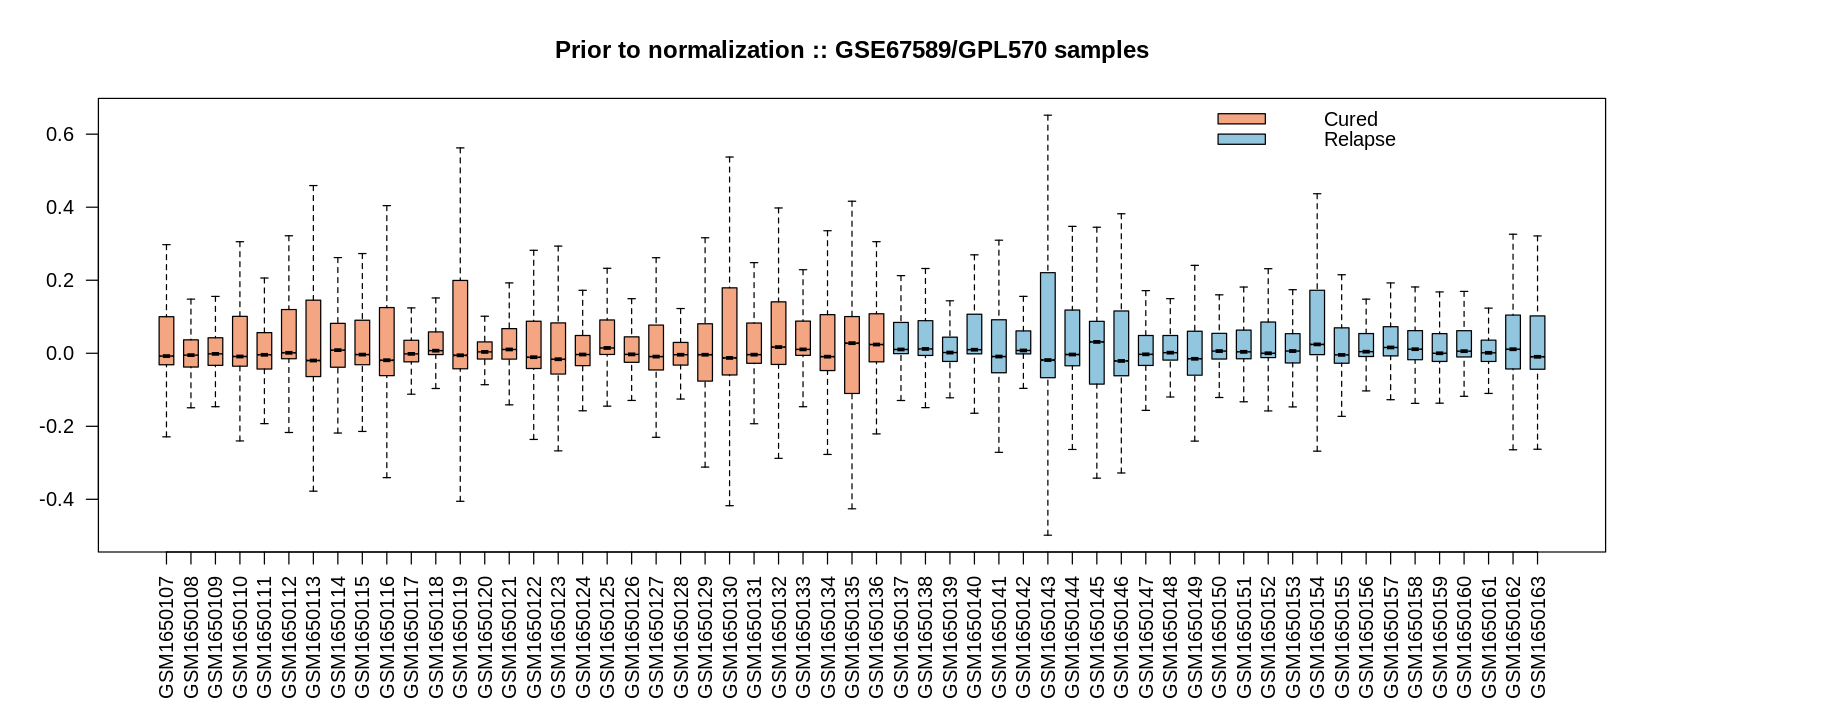

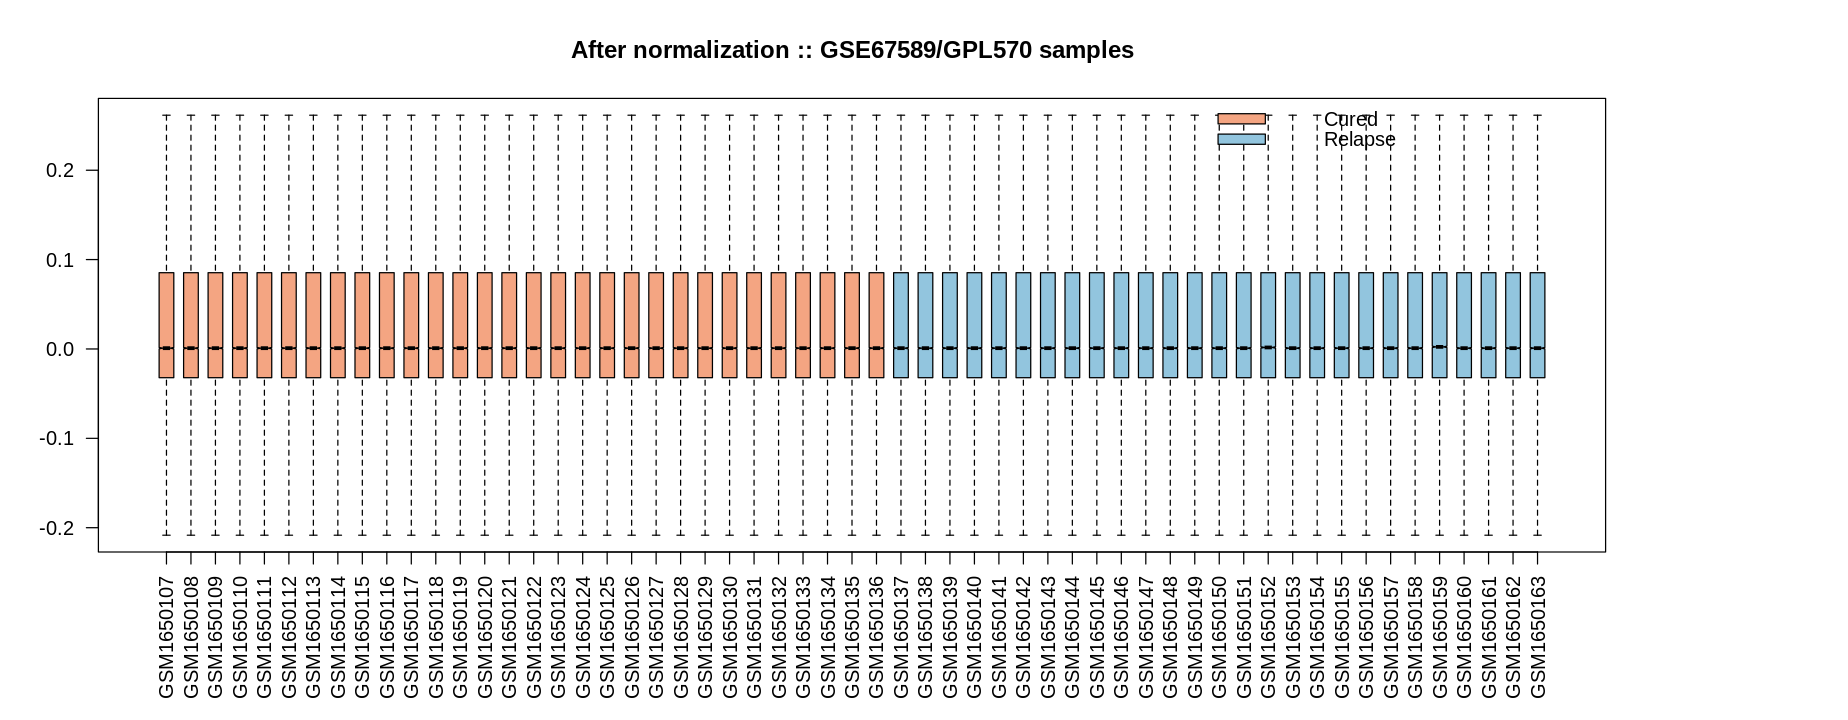

In [26]:
#Retrive GSE67589: South Africa 2015 cohort (assess risk of tuberculosis relapse following treatment)
GSE_ID <- "GSE67589"
#Fetch and process data
data <- array_process_qc(GSE_ID, 'timepoint:ch1', norm_exp_data, TRUE)

##################################################################
#Sort samples by time and patient
Info=data$pheno[,c('title','source_name_ch1','timepoint:ch1','treatment outcome:ch1')]
colnames(Info)=c('title','source','outcome','timepoint')
Info$patient <- gsub('^.*_Patient_(\\d.*)_.*$','\\1',Info$title)
Info$time <- as.vector(array(0,c(dim(Info)[1],1)))
Info[Info$timepoint=='Diagnosis','time'] <- 0
Info[Info$timepoint=='Week 2','time'] <- 14
Info[Info$timepoint=='Week 4','time'] <- 28 
Info <- Info[order(Info$patient,Info$time),]#Sort by patient and time

#Four groups from the cohort
Info$Treat_group <- as.vector(array(0,c(dim(Info)[1],1)))
Info[Info$time==0,'Treat_group'] <- 1
Info[Info$time==14,'Treat_group'] <- 2
Info[Info$time==28,'Treat_group'] <- 3 
Info$groupName <- as.vector(array(0,c(dim(Info)[1],1)))
Info[Info$Treat_group==1,'groupName'] <- '0d prior to treatment'
Info[Info$Treat_group==2,'groupName'] <- '14d after initial treatment'
Info[Info$Treat_group==3,'groupName'] <- '28d after initial treatment' 

#update _array_Exp_EachGene.csv _array_Exp_Info.csv
write.csv(data$gset[,rownames(Info)], paste0(norm_exp_data , GSE_ID, '_array_Exp_EachGene', '.csv'))
write.csv(Info, paste0(norm_exp_data , GSE_ID, '_array_Exp_Info', '.csv'))